In [48]:
%run 'data_preparation.ipynb'

In [19]:
from fbprophet import Prophet

In [86]:
year.tail()

,BOOKING_HAL_ID,CATEGORY_HAL_ID,VEHICLE_HAL_ID,CUSTOMER_HAL_ID,DATE_BOOKING,DATE_FROM,DATE_UNTIL,COMPUTE_EXTRA_BOOKING_FEE,TRAVERSE_USE,DISTANCE,...,BOOKING_DATE,FROM_DATE,BOOKING_YEAR,BOOKING_MONTH,BOOKING_WDAY,BOOKING_QUARTER,FROM_MONTH,UNTIL_MONTH,FROM_WDAY,UNTIL_WDAY
542932,43060293,100005,161830,FBFBE66F79A8407BF2DA061EB035A9E3BA60FB5C,2016-11-30 11:29:24,2016-11-30 09:05:46,2016-11-30 10:48:14,Nein,Nein,26,...,2016-11-30,2016-11-30,2016,11,2,4,11,11,2,2
542933,43070512,100005,161830,FBFBE66F79A8407BF2DA061EB035A9E3BA60FB5C,2016-11-30 21:22:43,2016-11-30 19:04:47,2016-11-30 21:20:02,Nein,Nein,57,...,2016-11-30,2016-11-30,2016,11,2,4,11,11,2,2
542934,43079191,100005,161830,FBFBE66F79A8407BF2DA061EB035A9E3BA60FB5C,2016-12-01 11:53:11,2016-12-01 09:10:44,2016-12-01 11:31:47,Nein,Nein,36,...,2016-12-01,2016-12-01,2016,12,3,4,12,12,3,3
542935,43087847,100005,161830,FBFBE66F79A8407BF2DA061EB035A9E3BA60FB5C,2016-12-01 19:59:15,2016-12-01 18:11:49,2016-12-01 19:58:13,Nein,Nein,34,...,2016-12-01,2016-12-01,2016,12,3,4,12,12,3,3
542936,43097826,100005,161830,FBFBE66F79A8407BF2DA061EB035A9E3BA60FB5C,2016-12-02 11:02:44,2016-12-02 09:06:58,2016-12-02 11:01:21,Nein,Nein,18,...,2016-12-02,2016-12-02,2016,12,4,4,12,12,4,4


In [87]:
per_day = year.pivot_table(index=['BOOKING_DATE'],values=['BOOKING_HAL_ID'], aggfunc=lambda x: len(x.unique()))

In [88]:
per_day.reset_index(inplace=True)
per_day.tail()

,BOOKING_DATE,BOOKING_HAL_ID
1091,2016-12-27,273
1092,2016-12-28,263
1093,2016-12-29,301
1094,2016-12-30,315
1095,2016-12-31,225


# Prediction with out holiday data

In [89]:
# Prophet requires columns ds (Date) and y (value)
per_day = per_day.rename(columns={'BOOKING_DATE': 'ds', 'BOOKING_HAL_ID': 'y'})
# Put market cap in billions
#per_day['y'] = per_day['y'] / 1e9
# Make the prophet model and fit on the data
per_day_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
per_day_prophet.fit(per_day)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [90]:
# Make a future dataframe for 2 years
per_day_forecast = per_day_prophet.make_future_dataframe(periods=24, freq='M')
# Make predictions
per_day_forecast = per_day_prophet.predict(per_day_forecast)

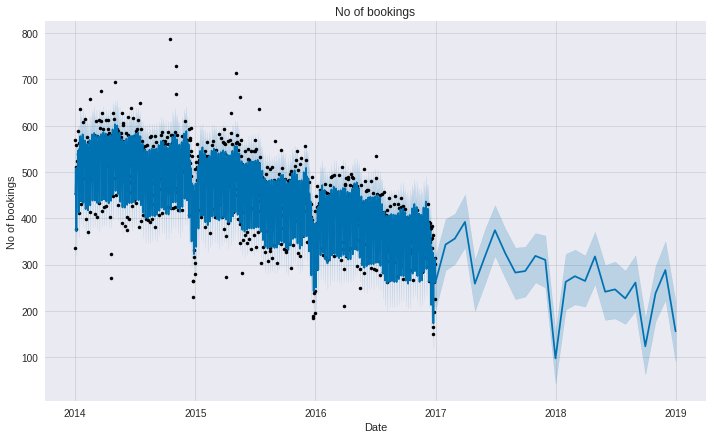

In [91]:
per_day_prophet.plot(per_day_forecast, xlabel = 'Date', ylabel = 'No of bookings')
plt.title('No of bookings');

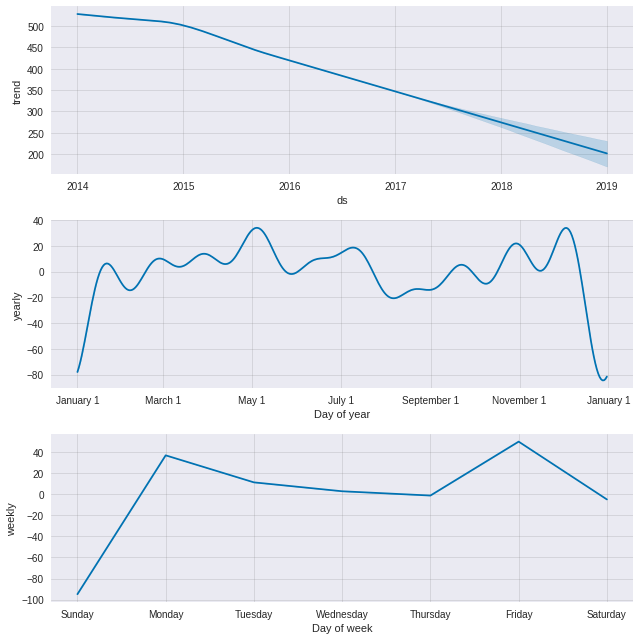

In [92]:
per_day_prophet.plot_components(per_day_forecast);

# Prediction with holiday data

In [93]:
promotions = pd.DataFrame({
  'holiday': holidays.PUBLIC_HOLIDAYS,
  'ds': holidays.BOOKING_DATE,
  'lower_window': 0,
  'upper_window': 0,
})

In [94]:
promotions.head()

,ds,holiday,lower_window,upper_window
0,01-01-2019,New Year's Day,0,0
1,30-03-2019,Good Friday,0,0
2,02-04-2019,Easter Monday,0,0
3,01-05-2019,Labour Day,0,0
4,10-05-2019,Ascension Day,0,0


In [95]:
model = Prophet(holidays=promotions)

In [96]:
model.fit(per_day)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [97]:
future = model.make_future_dataframe(periods=24, freq = 'm')
future.tail()

,ds
1115,2018-08-31
1116,2018-09-30
1117,2018-10-31
1118,2018-11-30
1119,2018-12-31


In [98]:
forecast = model.predict(future)

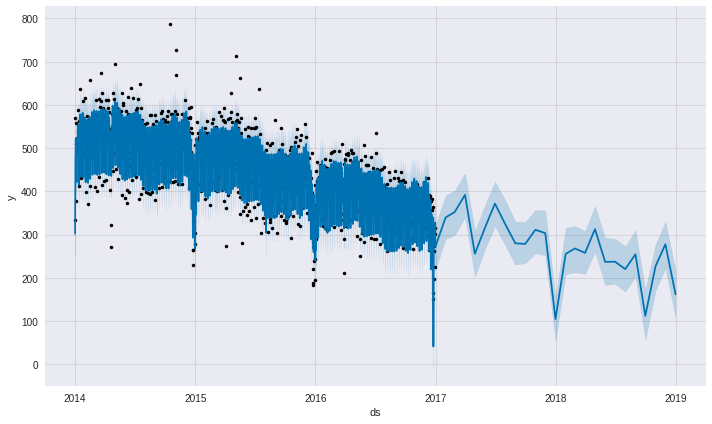

In [99]:
model.plot(forecast);

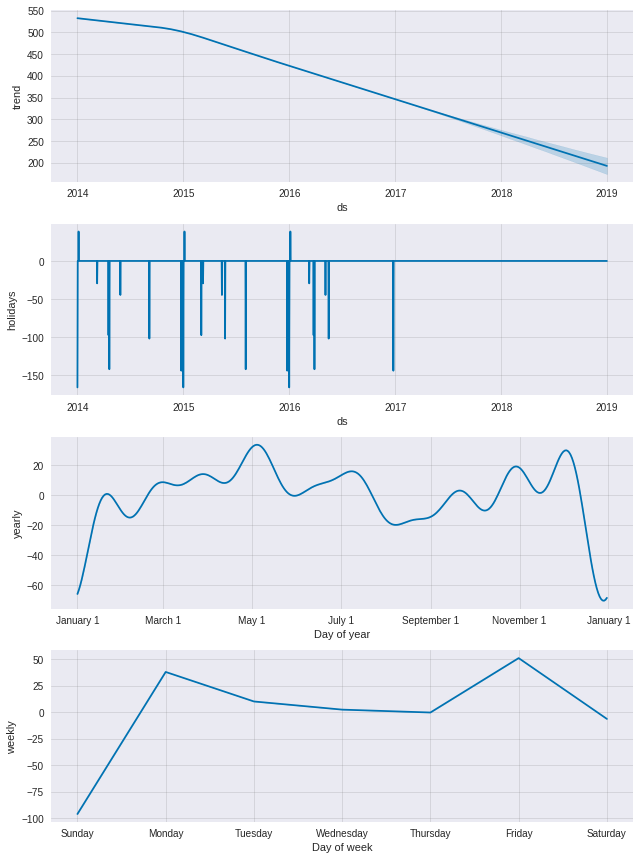

In [100]:
model.plot_components(forecast);

# Difference between holiday and non-holiday

In [101]:
forecast.head()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,Ascension Day,Ascension Day_lower,Ascension Day_upper,Christmas Day,...,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
0,2014-01-01,532.544024,532.544024,532.544024,251.634820,352.475555,0.0,0.0,0.0,0.0,...,-63.962594,-63.962594,-63.962594,2.588230,2.588230,2.588230,-66.550824,-66.550824,-66.550824,302.263656
1,2014-01-02,532.469375,532.469375,532.469375,412.099736,518.198887,0.0,0.0,0.0,0.0,...,-64.063811,-64.063811,-64.063811,-0.134404,-0.134404,-0.134404,-63.929407,-63.929407,-63.929407,468.405564
2,2014-01-03,532.394725,532.394725,532.394725,468.823179,577.311856,0.0,0.0,0.0,0.0,...,-9.475244,-9.475244,-9.475244,51.268290,51.268290,51.268290,-60.743533,-60.743533,-60.743533,522.919481
3,2014-01-04,532.320076,532.320076,532.320076,418.920197,525.866237,0.0,0.0,0.0,0.0,...,-63.241352,-63.241352,-63.241352,-6.173558,-6.173558,-6.173558,-57.067794,-57.067794,-57.067794,469.078723
4,2014-01-05,532.245426,532.245426,532.245426,373.236545,473.494627,0.0,0.0,0.0,0.0,...,-149.013216,-149.013216,-149.013216,-96.028519,-96.028519,-96.028519,-52.984697,-52.984697,-52.984697,421.946482


In [102]:
forecast.set_index('ds', inplace=True)
per_day_forecast.set_index('ds', inplace=True)
compared_df = forecast.join(per_day_forecast, rsuffix="_no_holiday")

In [103]:
compared_df= np.exp(compared_df[['yhat', 'yhat_no_holiday']])

In [104]:
compared_df['diff_per'] = 100*(compared_df['yhat'] - compared_df['yhat_no_holiday']) / compared_df['yhat_no_holiday']
compared_df.tail()

,yhat,yhat_no_holiday,diff_per
ds,,,
2018-08-31,4.136345e+110,3.366617e+113,-99.877136
2018-09-30,5.857619e+48,6.799220e+53,-99.999138
2018-10-31,3.792947e+98,2.293628e+103,-99.998346
2018-11-30,4.611711e+120,1.829132e+125,-99.997479
2018-12-31,2.336855e+70,7.533308e+67,30920.301253


In [105]:
compared_df['diff_per'].mean()

9.085326486593035e+20

# Effect of Changepoint Prior Scale

In [106]:
# Try 4 different changepoints
for changepoint in [0.001, 0.05, 0.1, 0.5]:
    model = fbprophet.Prophet(daily_seasonality=False, changepoint_prior_scale=changepoint)
    model.fit(per_day)
    
    future = model.make_future_dataframe(periods=12, freq='M')
    future = model.predict(future)
    
    per_day[changepoint] = future['yhat']

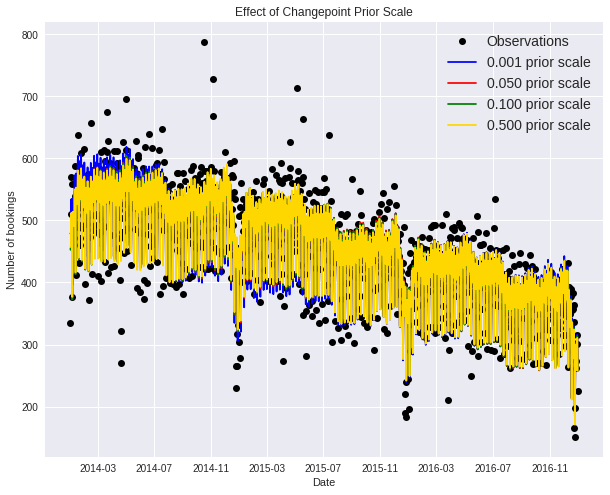

In [107]:
plt.figure(figsize=(10, 8))

# Actual observations
plt.plot(per_day['ds'], per_day['y'], 'ko', label = 'Observations')
colors = {0.001: 'b', 0.05: 'r', 0.1: 'green', 0.5: 'gold'}

# Plot each of the changepoint predictions
for changepoint in [0.001, 0.05, 0.1, 0.5]:
    plt.plot(per_day['ds'], per_day[changepoint], color = colors[changepoint], label = '%.3f prior scale' % changepoint)
    
plt.legend(prop={'size': 14})
plt.xlabel('Date'); plt.ylabel('Number of bookings'); plt.title('Effect of Changepoint Prior Scale');
